# Wisdom Tree Assignment

We start by importing the libraries that we will need later on

In [1]:
import numpy as np
import pandas as pd
import os.path as pth

import matplotlib.pyplot as plt

from time import time
from WT_functions import rebase_at_x
from WT_functions import backtest_strategy
from WT_functions import IndexConstruction
from WT_functions import single_commodity_optimal_contract
from WT_functions import plot_contract, plot_future_curve_and_roll_yield

## Get and Clean Data

As first steps, we:
- Get the dataframes we will need to perform the analysis from the `.csv` files, namely `contracts_prices.csv` and `contracts_info.csv`.
- Transform date columns into `pd.datetime`.
- Sort the DataFrame by index first (trading date), then by maturity year and maturity month.
- Merge the contracts' information DataFrame with `df` in order to compute the metrics that are involving the `contract_size`. 

In [2]:
filename = 'contracts_prices.csv' 
filename_info = 'contracts_info.csv'

filepath = pth.join(pth.join('Other', 'WisdomTree'), filename)  # insert here the right path
filepath_info = pth.join(pth.join('Other', 'WisdomTree'), filename_info)  # insert here the right path

df = pd.read_csv(filepath).set_index('date')
df_info = pd.read_csv(filepath_info).set_index('contract_code')
names_mapping = df_info.contract_short_name.to_dict()

# turn date columns into datetime dtype
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')
df.loc[:, 'last_trade_date'] = pd.to_datetime(df['last_trade_date'], format='%d/%m/%Y')

df = df.reset_index().sort_values(['date', 'mat_year', 'mat_month'], ascending=[True, False, False]).set_index('date')
df = df.merge(df_info, left_on='contract_code', right_index=True)

We define the value of the contract by multiplying the current price by the size of the contract. Then we compute the open interest and the volume in USD and the 1 month (22 business days) moving average of the latter.


In [3]:
df['value_USD'] = df.close.mul(df.contract_size)
df['oi_USD'] = df.oi.mul(df.value_USD).fillna(0)
df['volume_USD'] = df.volume.mul(df.value_USD).fillna(0)

lbls = ['contract_code', 'mat_month', 'mat_year']
volume_ma = df.groupby(lbls)['volume_USD'].rolling(window=22, min_periods=1).mean()
df = df.set_index(lbls, append=True).join(volume_ma, rsuffix='_1M_MA').reset_index().set_index('date')

We wrapped up the previous code in a single function called `get_and_tidy_up_data`. We print how long does it take to ingest and tidy up the data

In [4]:
from WT_functions import get_and_tidy_up_data
df, names_mapping = get_and_tidy_up_data(filename='contracts_prices.csv', filename_info='contracts_info.csv')

func:'get_and_tidy_up_data' args:[(), {'filename': 'contracts_prices.csv', 'filename_info': 'contracts_info.csv'}] took: 10.4854 sec


## Some Plots

Now we use the function `plot_contract` to plot the metrics relative to specific contracts. 

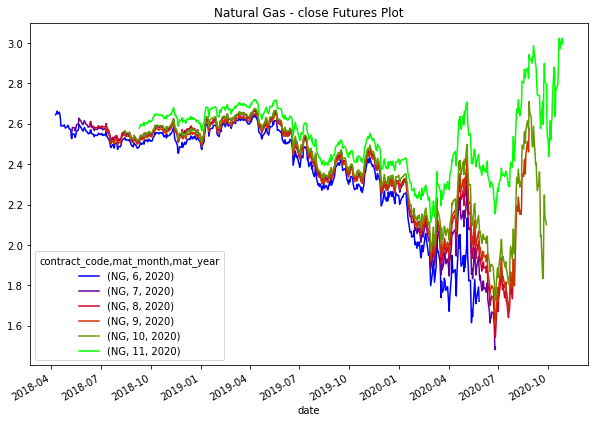

In [5]:
plot_contract('close', df, 'NG', [6, 7, 8, 9, 10, 11], [2020], names_mapping)

Below we plot the graphs of USD volume and open interest in log scale, so it's more clear when a contract availability kicks in.

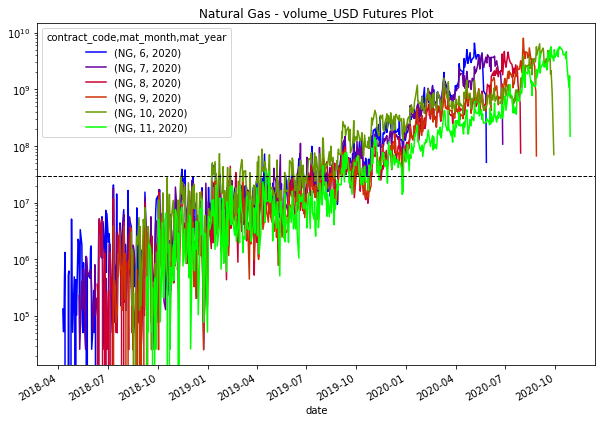

In [6]:
plot_contract('volume_USD', df, 'NG', [6, 7, 8, 9, 10, 11], [2020], names_mapping)

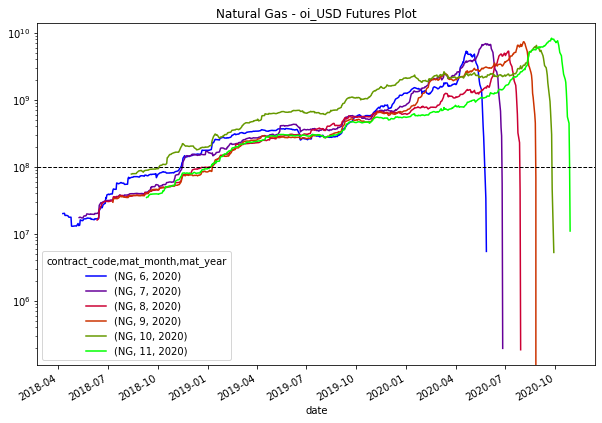

In [7]:
plot_contract('oi_USD', df, 'NG', [6, 7, 8, 9, 10, 11], [2020], names_mapping)

## Optimal Future Maturity

For each one of the commodity we have to find the *optimal future maturity* on the last day of each month. In order to to this, we first find the *optimal future maturity contract* for each day and then we will resample the Dataframe obtained in order to sample the right contract at each month end.

With the **implied roll yield** defined as

$$\text{Implied Roll Yield}_i = \bigg( \frac{\text{Price of contract}_{i-1}}{\text{Price of contract}_{i}} - 1 \bigg) \frac{1}{\text{# of months between the contracts}}$$

The **optimal future maturity** is defined, for each date, as the contract $i$ that satisfies:

$$\max_i \bigg( \text{Implied Roll Yield}_i \bigg)$$

Given that the it has an **open interest of at least 100 USD/mln** and **1-month average daily USD volume of at least 30 USD/mln**. We show the steps done in order to get to these values for one single commodity for clarity, namely Natural Gas.

In [8]:
volume_threshold=3e7
oi_threshold=1e8

cols = ['contract_code', 'mat_month', 'mat_year']  # columns employed in the groupbys

ng = df[df.contract_code == 'NG']

First let's put the close prices of every contract into a dataframe where the index is the date and the columns are the contracts. We will need them later on to perform the strategy.

In [9]:
price_ng_comm = ng.set_index(cols, append=True).loc[:, 'close'].unstack(cols)

# sort the columns properly
price_ng_comm.sort_index(level='mat_year', axis=1, inplace=True)

Now compute the **number of days between two consecutive contracts** and divide that by 30 (as a representative number for of number of days in one month). We obtain the column `delta_months`, that we will use in the calculation of the implied roll yield. To perform this operation and some of the following operations we will use the `groupby()` method of `pandas`, which allows some fast vectorized manipulation of data.

In [10]:
ng_grouped = ng.reset_index().groupby(['date', 'contract_code'])
delta_days = ng_grouped['last_trade_date'].diff().abs().dt.days.shift(-1)
delta_days.index = ng.index
ng.loc[:, 'delta_days'] = delta_days
ng.loc[:, 'delta_months'] = delta_days / 30

C:\Users\ilsup\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Then we compute the **roll yield for each contract**; we compute it with the simple `pct_change()` method. The contracts are ordered in such the way that `pct_change()` and a subsequent shift backwards of one day assign to each contract the right roll yield.

In [11]:
roll_yield_raw = ng_grouped['close'].pct_change().shift(-1)
roll_yield_raw.index = ng.index
ng.loc[:, 'roll_yield_raw'] = roll_yield_raw
ng.loc[:, 'roll_yield'] = ng['roll_yield_raw'].div(ng['delta_months'])

Finally we filter each contract by the volume and open interest requirements

In [12]:
ng_flt = ng[(ng.volume_USD_1M_MA > volume_threshold) & (ng.oi_USD > oi_threshold)]

Now we have all the eligible contracts and the relative roll yields. The last thing to do is to **select the maximum one** per day

In [13]:
chosen_contracts_idx = list(ng_flt.reset_index().groupby(['date', 'contract_code'])['roll_yield'].idxmax().dropna().values.astype(int))
chosen_contracts = ng_flt.reset_index().iloc[chosen_contracts_idx].set_index('date')

Once we have all the "optimal" contracts, we simply

In [14]:
w_ng_mask = ~chosen_contracts.set_index(cols, append=True).loc[:, 'close'].unstack(cols).isnull()
w_ng = w_ng_mask.astype(float)  # convert bool for chosen contract in a float

# make sure that the weight matrix and price matrix have same indexes
w_ng = w_ng.reindex(price_ng_comm.index).reindex(price_ng_comm.columns, axis=1)
w_ng_mask = w_ng_mask.reindex(price_ng_comm.index).reindex(price_ng_comm.columns, axis=1)

We perform a small check in order to verify that only one contract is chosen by each date.

In [15]:
w_ng.sum(axis=1).sum() == w_ng.shape[0]

True

### Visualize Optimal Future Maturity

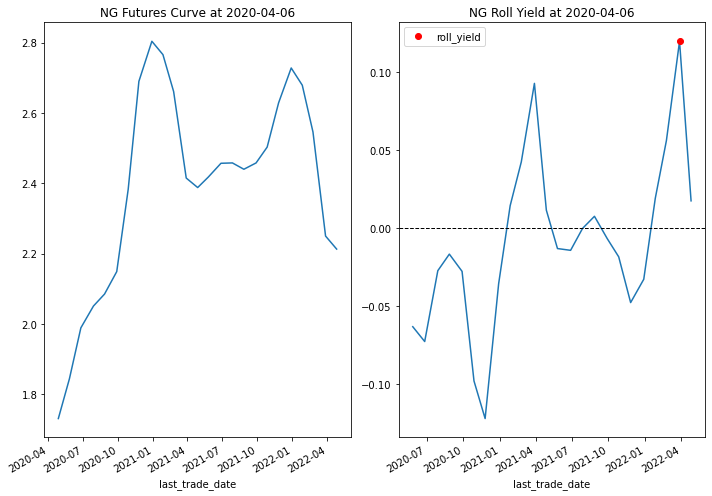

In [16]:
plot_future_curve_and_roll_yield(ng.loc[pd.to_datetime('2020-04-06')])

In the graph above we wanted to show visually ho the optimal maturity choice works. We plot on the right the **futures curve** for Natural gas. On the *x-axis* we have the **maturity** of the contracts and the **price** on the *y-axis*. We can notice the seasonality typical of natural gas futures. 

On the right hand side we have the roll yields and, **in red, the optimal one**. By selecting the contract with the highest roll yield we are basically trying to get the contract that, given the same futures curve shape, will have the highest percentage price pick up.

## Optimal Yield Choice Wrap Up

We wrap up everything in following `for` cycle. The function `single_commodity_optimal_contract`, for each commodity, performs the steps that we outlined previously and stores them in three dictionaries:
- `price_df_dict`: close prices are stored in dataframes where the index is the date and the columns are the contracts.
- `contracts_df_dict`: all the contracts with relative roll yields
- `chosen_contracts_dict`: where the contracts with the highest roll yield are stored. From this dictionary we will create the dataframe to be save in an excel file
- `weights_dict`

In [17]:
pd.options.mode.chained_assignment = None  # disable warning

# initialize dictionaries
weights_dict = {}
price_df_dict = {}
contracts_df_dict = {}
chosen_contracts_dict = {}

for cd in df.contract_code.unique():
    print('Choose Optimal Contract for Single Commodity: {}'.format(cd))
    contracts_df_single, chosen_contracts_single, price_df_single_comm, weights_single = \
        single_commodity_optimal_contract(df[df.contract_code == cd])
    
    weights_dict[cd] = weights_single
    price_df_dict[cd] = price_df_single_comm
    contracts_df_dict[cd] = contracts_df_single
    chosen_contracts_dict[cd] = chosen_contracts_single

Choose Optimal Contract for Single Commodity: LA
Choose Optimal Contract for Single Commodity: CL
Choose Optimal Contract for Single Commodity: LP
Choose Optimal Contract for Single Commodity: XB
Choose Optimal Contract for Single Commodity: HO
Choose Optimal Contract for Single Commodity: NG
Choose Optimal Contract for Single Commodity: C
Choose Optimal Contract for Single Commodity: GC
Choose Optimal Contract for Single Commodity: KC
Choose Optimal Contract for Single Commodity: W
Choose Optimal Contract for Single Commodity: LX
Choose Optimal Contract for Single Commodity: SI
Choose Optimal Contract for Single Commodity: S
Choose Optimal Contract for Single Commodity: SB
Choose Optimal Contract for Single Commodity: LC


We turn the `chosen_contracts_dict` into a Dataframe and save it as `optimal_maturity.xls`

In [18]:
pd.concat(chosen_contracts_dict).to_excel('optimal_maturity.xlsx')

We can also see the evolution of the **optimal roll yield over time**, this time for instance for WTI Crude  

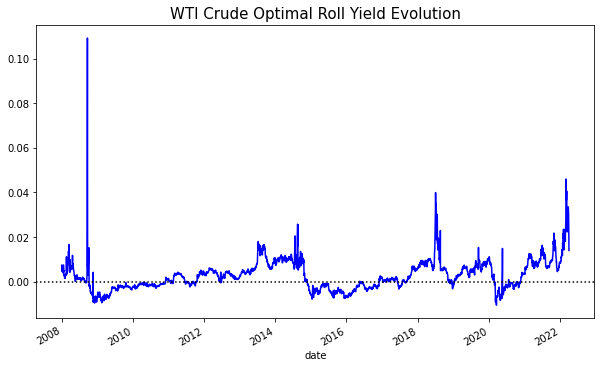

In [19]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
chosen_contracts_dict['CL'].roll_yield.plot(ax=ax, cmap='brg')
ax.set_title('{} Optimal Roll Yield Evolution'.format(names_mapping['CL']), fontsize=15)
ax.axhline(0, color='black', linestyle='dotted')
fig.savefig('opt_roll_yield_evo.png')
plt.show()

## Backtesting the Strategy 



If we want to start from this section set `start_from_here` in the following cell equal to `True`

In [20]:
start_from_here = False

if start_from_here:
    weights = pd.read_pickle('weights')
    price_df = pd.read_pickle('price_df')

else:
    price_df = pd.concat(price_df_dict, axis=1)
    weights = pd.concat(weights_dict, axis=1)

### Step by Step
As we did before, we show the steps of the backtesting process. First we select our sample commodity, natural gas. Second, **we shift the weights one day forward**. Indeed, the information regarding the optimal roll yield will be only implemented at the end of the day and available the day after

In [21]:
cd = 'NG'

price_df_single = price_df.loc[:, cd]
weights_single = weights.loc[:, cd]

weights = weights.shift().dropna(how='all')
price_df = price_df.truncate(before=weights.index[0])

We first drop the commodity column level and collapse all the other column levels into one single level. 

In [22]:
w = weights_single.copy()
prices = price_df_single.copy()

w.columns = w.columns.droplevel(0)
prices.columns = prices.columns.droplevel(0)

# create single level column to pass the DataFrame
w.columns = ['_'.join(map(str, x)) for x in w.columns]
prices.columns = ['_'.join(map(str, x)) for x in prices.columns]

We use the small class `IndexConstruction` in order to build the strategy. 
- We first resample the weights at the first month business day by setting `resample('BMS')`. This is equivalent to rebalancing the portfolio the last business day of the month with the new rebalanced weights effective only from the first day of the following month.
- We use `reindex()`, `ffill()` and `bfill()` in order to "expand" the weights and make them of the same shape of the price Dataframe. We are allowed to do that because we invest only in one instrument at a time.
- We set `shift_periods = 0` since we already shifted the weights in a previous step.

In [23]:
weights_at_reb_dt = w.resample('BMS').first().fillna(0).reindex(prices.index).ffill().bfill()

In [24]:
idx_cls = IndexConstruction(prices, weights_at_reb_dt.T, name='strategy', shift_periods=0)
idx_cls.get_index()

A way to visualize the contracts chosen is to see the heatmap of the weights for a single commodity (only 2000 days are shown). On the *y-axis* we have the dates and, on the *x-axis*, we have the specific contracts (we avoided to write the contract names). The purple stripe represents all the contracts available at a given date. The yellow one is the chosen one at each date.

C:\Users\ilsup\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


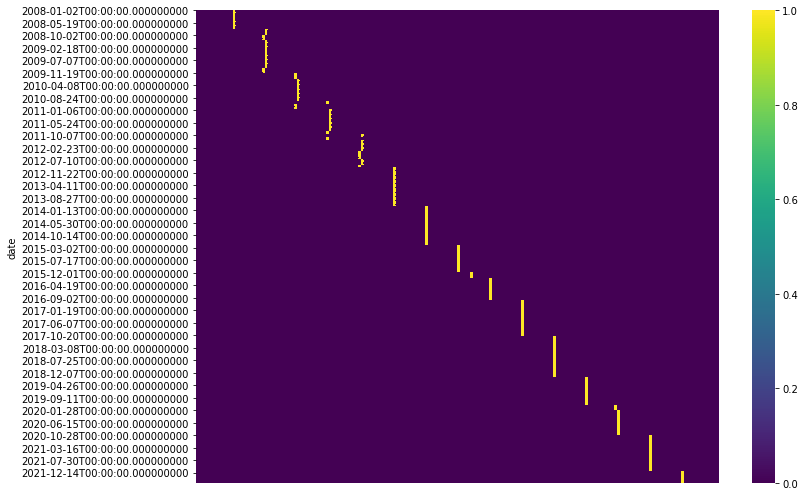

In [25]:
idx_cls.plot_weights()

### Monthly Backtesting

Now we will carry one the previous steps for each one of the commodities. The steps are wrapped up in the `backtest_strategy()` function 

In [26]:
codes = df.contract_code.unique()

price_df = pd.concat(price_df_dict, axis=1)
weights = pd.concat(weights_dict, axis=1)

weights = weights.dropna(how='all')
price_df = price_df.truncate(before=weights.index[0])

# drop the contracts that are never used to make the code a bit faster
empty_contracts = weights.sum()[weights.sum() == 0].index
price_df = price_df.drop(empty_contracts, axis=1)
weights = weights.drop(empty_contracts, axis=1)

ts_dict = {}
for cd in codes:
    print('Backtest Strategy For Single Commodity: {} - {}'.format(cd, 'Monthly Rebalancing'))
    price_df_single = price_df.loc[:, cd]
    weights_single = weights.loc[:, cd]
    strategy_class, strategy_ts = backtest_strategy(prices=price_df_single, w=weights_single)
    ts_dict[cd] = strategy_ts

Backtest Strategy For Single Commodity: LA - Monthly Rebalancing
Backtest Strategy For Single Commodity: CL - Monthly Rebalancing
Backtest Strategy For Single Commodity: LP - Monthly Rebalancing
Backtest Strategy For Single Commodity: XB - Monthly Rebalancing
Backtest Strategy For Single Commodity: HO - Monthly Rebalancing
Backtest Strategy For Single Commodity: NG - Monthly Rebalancing
Backtest Strategy For Single Commodity: C - Monthly Rebalancing
Backtest Strategy For Single Commodity: GC - Monthly Rebalancing
Backtest Strategy For Single Commodity: KC - Monthly Rebalancing
Backtest Strategy For Single Commodity: W - Monthly Rebalancing
Backtest Strategy For Single Commodity: LX - Monthly Rebalancing
Backtest Strategy For Single Commodity: SI - Monthly Rebalancing
Backtest Strategy For Single Commodity: S - Monthly Rebalancing
Backtest Strategy For Single Commodity: SB - Monthly Rebalancing
Backtest Strategy For Single Commodity: LC - Monthly Rebalancing


We plot the resulting time series for Natural Gas

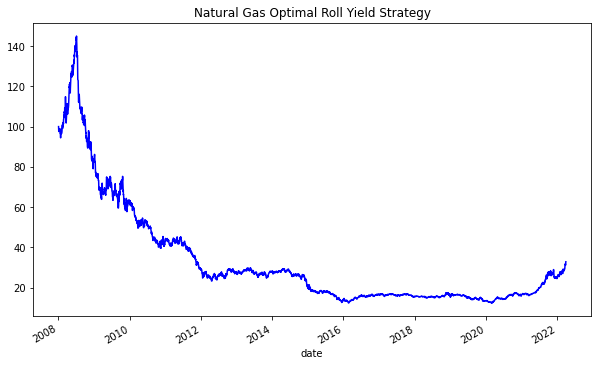

In [27]:
ts_dict['NG'].plot(figsize=(10, 6), title='Natural Gas Optimal Roll Yield Strategy', cmap='brg')
plt.show()

Finally we can pull everything together. We treat the 15 time series as if they were separated portfolios. We resample them at the first day of the month again and then average over their returns, in order to obtain a **monthly equal weighing strategy**.

In [28]:
print('Backtest Full Strategy')
full_comm_df = pd.concat(ts_dict, axis=1)
resampled_full_comm = full_comm_df.resample('BMS').first()
ptf_ts = rebase_at_x((resampled_full_comm.pct_change().mean(axis=1).fillna(0) + 1).cumprod())  # compute ptf ts
ptf_ts.name = 'strategy'

Backtest Full Strategy


We plot the strategy with the various commodities and alone.

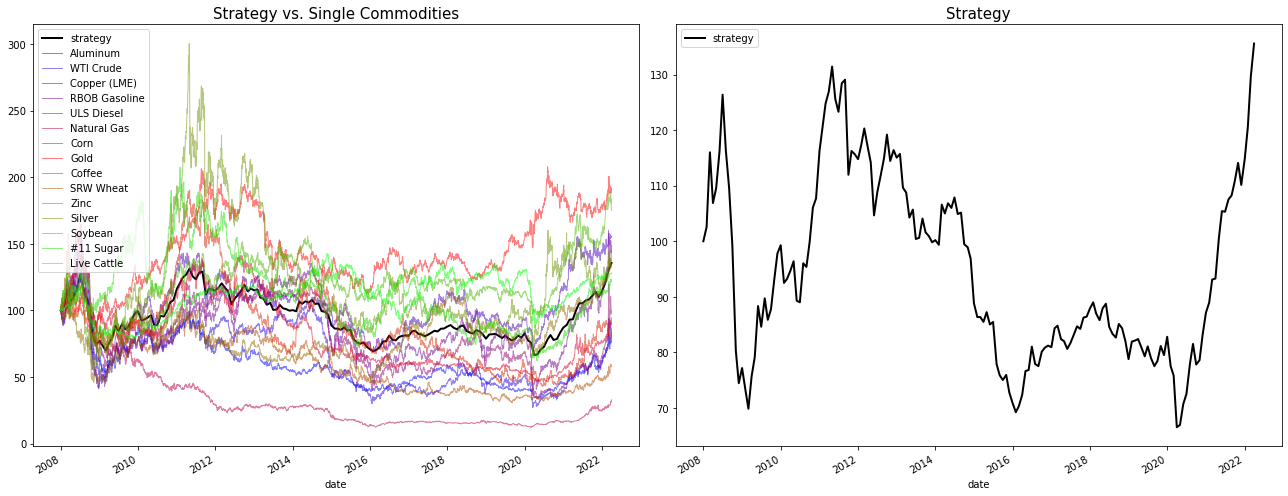

In [29]:
fig = plt.figure(figsize=(18, 7))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ptf_ts.plot(color='black', ax=ax, legend='strategy', linewidth=2)
ptf_ts.plot(color='black', ax=ax2, legend='strategy', linewidth=2)
full_comm_df.rename(names_mapping, axis=1).plot(cmap='brg', ax=ax, alpha=0.5, linewidth=1)
ax.set_title('Strategy vs. Single Commodities', fontsize=15)
ax2.set_title('Strategy', fontsize=15)
plt.tight_layout()
plt.show()

## Stats Computation

By calling the class `Stats` we compute all the statistics for the portfolio and for the single strategies. We call the method `summary_stats()` that computes the basic metrics, like performance, volatility, drawdown and sharpe ratio

In [31]:
from WT_functions import Stats
# Stats computation for the Strategy and export
stats = Stats(ptf_ts.to_frame().pct_change())
summary_stats = stats.summary_stats()
summary_stats.to_excel('strategy_stats.xlsx')

In [32]:
# Stats computation for all the Commodities and export
stats_comm = Stats(full_comm_df.pct_change())
summary_stats_comm = stats_comm.summary_stats()
summary_stats_comm = summary_stats_comm.rename(names_mapping, axis=1).T
summary_stats_comm.to_excel('commodities_stats.xlsx')

## Proposal

The most straightforward way to improve the framework above is to drift from an equally weighted portoflio and to tilt the weights depending on:

- The **value of the roll yield** (in cross section or vs its own history), where higher yields commodities take a higher weight
- The maturity of the contract chosen
- A combination of the two